In [67]:
# ==========================================
# CELL 1: MOUNT DRIVE & SETUP
# ==========================================
import os
from google.colab import drive

# Mount Google Drive to save the model
drive.mount('/content/drive')

# Create folder for saving models
SAVE_DIR = '/content/drive/MyDrive/BanglaSER_Project/'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'bangla_ser_best.pth')
print(f"Model will be saved to: {MODEL_SAVE_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model will be saved to: /content/drive/MyDrive/BanglaSER_Project/bangla_ser_best.pth


In [68]:
!pip install -q torchaudio librosa matplotlib seaborn scikit-learn gradio tqdm

In [69]:
# ==========================================
# CELL 2: INSTALL LIBRARIES
# ==========================================
# !pip install -q torchaudio librosa matplotlib seaborn scikit-learn gradio tqdm

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import gradio as gr

print("All libraries installed")


All libraries installed


In [70]:
# ==========================================
# CELL 3: CONFIGURATION
# ==========================================
CONFIG = {
    "SR": 16000,            # Sample Rate
    "DURATION": 4,          # Audio length in seconds
    "N_MFCC": 40,           # Feature dimension
    "BATCH_SIZE": 32,
    "EPOCHS": 30,
    "LR": 0.001,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "SEED": 42
}

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['SEED'])
print(f"Device: {CONFIG['DEVICE']}")


Device: cuda


In [71]:
# ==========================================
# CELL 4: LOAD DATASET
# ==========================================
# CHANGE THIS PATH to wherever you uploaded the dataset
DATASET_PATH = '/content/drive/MyDrive/BanglaSER_Project/BanglaSER/'

def load_audio_files(root_path):
    data = []

    # Emotion mapping
    # Updated to map 'natural' to the neutral emotion label
    emotion_map = {
        'angry': 0, 'happy': 1, 'sad': 2,
        'natural': 3, 'surprise': 4 # Changed 'neutral' to 'natural'
    }

    for root, dirs, files in os.walk(root_path):
        # Extract emotion from the parent directory name
        parent_dir_name = os.path.basename(root).lower()

        label = None
        for emotion, idx in emotion_map.items():
            if emotion in parent_dir_name: # Check if emotion is in parent directory name
                label = idx
                break

        # Only process files if a valid label was found for this directory
        if label is not None:
            for file in files:
                if file.endswith('.wav'):
                    filepath = os.path.join(root, file)
                    data.append({'path': filepath, 'label': label})

    return pd.DataFrame(data)

df = load_audio_files(DATASET_PATH)
print(f"Loaded {len(df)} files")
print(df.head())


Loaded 1080 files
                                                path  label
0  /content/drive/MyDrive/BanglaSER_Project/Bangl...      3
1  /content/drive/MyDrive/BanglaSER_Project/Bangl...      3
2  /content/drive/MyDrive/BanglaSER_Project/Bangl...      3
3  /content/drive/MyDrive/BanglaSER_Project/Bangl...      3
4  /content/drive/MyDrive/BanglaSER_Project/Bangl...      3


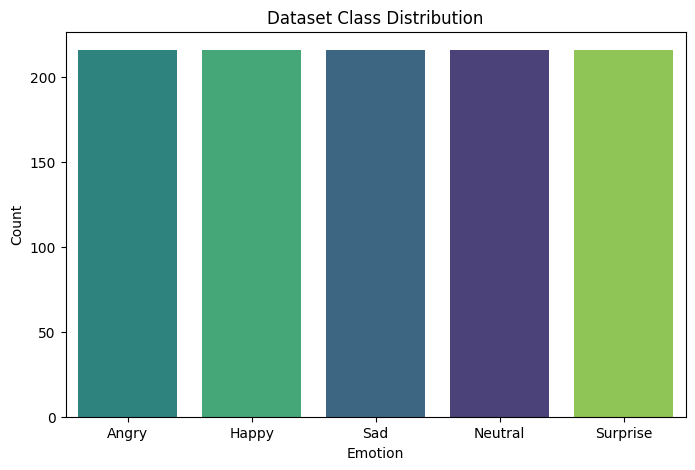

In [72]:
# ==========================================
# CELL 5: DATA DISTRIBUTION
# ==========================================
emotion_names = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral', 4: 'Surprise'}
df['emotion'] = df['label'].map(emotion_names)

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='emotion', order=['Angry', 'Happy', 'Sad', 'Neutral', 'Surprise'], palette='viridis', hue='emotion', legend=False)
plt.title("Dataset Class Distribution")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.show()

Sample: Sad


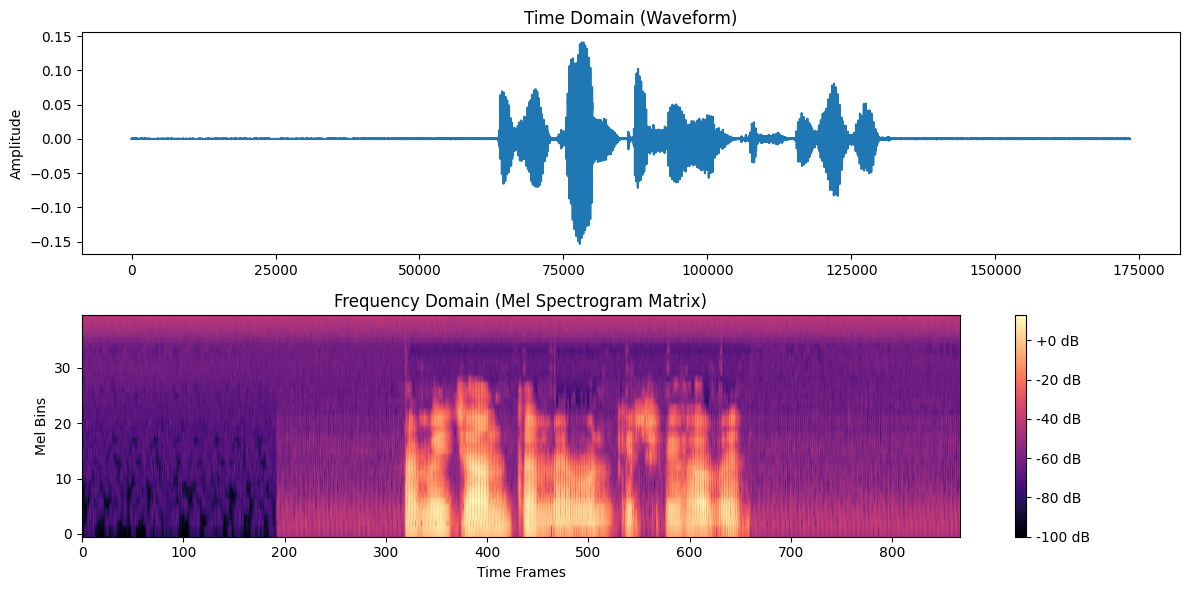

In [73]:
# ==========================================
# CELL 6: AUDIO WAVEFORM & SPECTROGRAM
# ==========================================
def visualize_audio(filepath):
    waveform, sr = torchaudio.load(filepath)

    fig, axes = plt.subplots(2, 1, figsize=(12, 6))

    # Time domain
    axes[0].plot(waveform.t().numpy())
    axes[0].set_title("Time Domain (Waveform)")
    axes[0].set_ylabel("Amplitude")

    # Frequency domain (Spectrogram - Linear Algebra)
    spec_transform = T.MelSpectrogram(sample_rate=sr, n_mels=40)
    spec = spec_transform(waveform)
    spec_db = T.AmplitudeToDB()(spec)

    im = axes[1].imshow(spec_db[0].numpy(), aspect='auto', origin='lower', cmap='magma')
    axes[1].set_title("Frequency Domain (Mel Spectrogram Matrix)")
    axes[1].set_ylabel("Mel Bins")
    axes[1].set_xlabel("Time Frames")
    plt.colorbar(im, ax=axes[1], format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

# Visualize random sample
sample = df.sample(1).iloc[0]
print(f"Sample: {sample['emotion']}")
visualize_audio(sample['path'])

In [76]:
# ==========================================
# CELL 7: PYTORCH DATASET CLASS (FIXED)
# ==========================================
class AudioDataset(Dataset):
    def __init__(self, dataframe, config):
        self.paths = dataframe['path'].values
        self.labels = dataframe['label'].values
        self.config = config

        # Audio Transforms
        self.mel_spec = T.MelSpectrogram(
            sample_rate=config['SR'],
            n_fft=1024,
            hop_length=512,
            n_mels=config['N_MFCC']
        )
        self.to_db = T.AmplitudeToDB()

    def __len__(self):
        return len(self.paths)

    def _process_audio(self, waveform):
        # 1. Force Mono (Fix for Stereo Error)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # 2. Fix Length (Pad or Cut)
        target_len = self.config['SR'] * self.config['DURATION']
        current_len = waveform.shape[1]

        if current_len < target_len:
            waveform = torch.nn.functional.pad(waveform, (0, target_len - current_len))
        else:
            waveform = waveform[:, :target_len]
        return waveform

    def __getitem__(self, idx):
        try:
            # Load
            waveform, sr = torchaudio.load(self.paths[idx])

            # Resample
            if sr != self.config['SR']:
                waveform = T.Resample(sr, self.config['SR'])(waveform)

            # Process (Mono + Length)
            waveform = self._process_audio(waveform)

            # Feature Extract
            spec = self.mel_spec(waveform)
            spec = self.to_db(spec)

            # Shape Check: Ensure (1, n_mels, time) -> (n_mels, time)
            if spec.dim() == 3 and spec.shape[0] == 1:
                spec = spec.squeeze(0)

            # Transpose for LSTM: (Frequency, Time) -> (Time, Frequency)
            # Result shape: (Time_Steps, 40)
            return spec.permute(1, 0), torch.tensor(self.labels[idx], dtype=torch.long)

        except Exception as e:
            print(f"Error loading {self.paths[idx]}: {e}")
            # Return a dummy tensor to prevent crashing
            dummy_spec = torch.zeros(126, self.config['N_MFCC']) # Approx time steps for 4s
            return dummy_spec, torch.tensor(self.labels[idx], dtype=torch.long)

# Re-create Splits & Loaders
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=CONFIG['SEED'])

train_dataset = AudioDataset(train_df, CONFIG)
test_dataset = AudioDataset(test_df, CONFIG)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False)

print(f" Fixed Dataset! Train: {len(train_dataset)} | Test: {len(test_dataset)}")


 Fixed Dataset! Train: 864 | Test: 216


In [77]:
# ==========================================
# CELL 8: P-VALUE ANALYSIS
# ==========================================
# We collect one batch to test if features statistically differentiate emotions
try:
    features, labels = next(iter(test_loader))

    # Average over time dimension: (Batch, Time, Mel) -> (Batch, Mel) -> Mean of Mels
    features_np = features.mean(dim=1).mean(dim=1).numpy()
    labels_np = labels.numpy()

    # ANOVA Test
    groups = [features_np[labels_np == i] for i in range(5) if len(features_np[labels_np == i]) > 0]

    if len(groups) > 1:
        stat, p_val = f_oneway(*groups)
        print(f"F-Statistic: {stat:.4f}")
        print(f"P-Value: {p_val:.4e}")
        if p_val < 0.05:
            print("Result: Significant (Features effectively separate emotions)")
        else:
            print(" Result: Not Significant")
    else:
        print(" Not enough classes in this batch for P-Value test.")
except Exception as e:
    print(f" Skipped P-Value test due to data shape issue: {e}")


F-Statistic: 1.9234
P-Value: 1.3534e-01
 Result: Not Significant


In [78]:
# ==========================================
# CELL 9: LSTM MODEL DEFINITION
# ==========================================
class BanglaLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BanglaLSTM, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        # x: (Batch, Time, Features)
        out, _ = self.lstm(x)

        # Take last time step
        last_step = out[:, -1, :]
        last_step = self.bn(last_step)

        return self.fc(last_step)

model = BanglaLSTM(CONFIG['N_MFCC'], 128, 5).to(CONFIG['DEVICE'])
print(model)


BanglaLSTM(
  (lstm): LSTM(40, 128, num_layers=2, batch_first=True, dropout=0.3)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [79]:
# ==========================================
# CELL 10: TRAINING LOOP
# ==========================================
optimizer = optim.Adam(model.parameters(), lr=CONFIG['LR'])
criterion = nn.CrossEntropyLoss()

history = {'t_loss': [], 'v_loss': [], 't_acc': [], 'v_acc': []}
best_acc = 0.0

print(f" Starting Training... Saving to: {MODEL_SAVE_PATH}")

for epoch in range(CONFIG['EPOCHS']):
    # Training
    model.train()
    t_loss, t_corr, t_tot = 0, 0, 0

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        X, y = X.to(CONFIG['DEVICE']), y.to(CONFIG['DEVICE'])

        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        t_loss += loss.item()
        t_corr += (out.argmax(1) == y).sum().item()
        t_tot += y.size(0)

    # Validation
    model.eval()
    v_loss, v_corr, v_tot = 0, 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(CONFIG['DEVICE']), y.to(CONFIG['DEVICE'])
            out = model(X)
            v_loss += criterion(out, y).item()
            v_corr += (out.argmax(1) == y).sum().item()
            v_tot += y.size(0)

    # Stats
    t_acc = 100 * t_corr / t_tot
    v_acc = 100 * v_corr / v_tot
    history['t_loss'].append(t_loss/len(train_loader))
    history['v_loss'].append(v_loss/len(test_loader))
    history['t_acc'].append(t_acc)
    history['v_acc'].append(v_acc)

    print(f"Epoch {epoch+1}: Train Acc={t_acc:.2f}% | Val Acc={v_acc:.2f}%")

    # Save Best Model
    if v_acc > best_acc:
        best_acc = v_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  Best Model Saved ({v_acc:.2f}%)")


 Starting Training... Saving to: /content/drive/MyDrive/BanglaSER_Project/bangla_ser_best.pth


Epoch 1: Train Acc=26.62% | Val Acc=39.81%
  Best Model Saved (39.81%)


Epoch 2: Train Acc=35.65% | Val Acc=42.59%
  Best Model Saved (42.59%)


Epoch 3: Train Acc=41.32% | Val Acc=50.46%
  Best Model Saved (50.46%)


Epoch 4: Train Acc=46.99% | Val Acc=35.65%


Epoch 5: Train Acc=49.07% | Val Acc=48.61%


Epoch 6: Train Acc=52.31% | Val Acc=50.00%


Epoch 7: Train Acc=57.06% | Val Acc=37.04%


Epoch 8: Train Acc=56.13% | Val Acc=42.59%


Epoch 9: Train Acc=58.45% | Val Acc=54.63%
  Best Model Saved (54.63%)


Epoch 10: Train Acc=62.15% | Val Acc=44.91%


Epoch 11: Train Acc=65.86% | Val Acc=55.09%
  Best Model Saved (55.09%)


Epoch 12: Train Acc=70.25% | Val Acc=49.07%


Epoch 13: Train Acc=65.62% | Val Acc=54.63%


Epoch 14: Train Acc=72.22% | Val Acc=58.33%
  Best Model Saved (58.33%)


Epoch 15: Train Acc=72.45% | Val Acc=50.93%


Epoch 16: Train Acc=76.74% | Val Acc=45.83%


Epoch 17: Train Acc=78.94% | Val Acc=64.35%
  Best Model Saved (64.35%)


Epoch 18: Train Acc=77.89% | Val Acc=51.39%


Epoch 19: Train Acc=78.12% | Val Acc=66.20%
  Best Model Saved (66.20%)


Epoch 20: Train Acc=82.18% | Val Acc=55.09%


Epoch 21: Train Acc=80.56% | Val Acc=59.72%


Epoch 22: Train Acc=81.60% | Val Acc=69.44%
  Best Model Saved (69.44%)


Epoch 23: Train Acc=84.61% | Val Acc=62.96%


Epoch 24: Train Acc=85.30% | Val Acc=65.28%


Epoch 25: Train Acc=87.96% | Val Acc=62.96%


Epoch 26: Train Acc=88.66% | Val Acc=65.28%


Epoch 27: Train Acc=88.31% | Val Acc=63.89%


Epoch 28: Train Acc=88.19% | Val Acc=66.67%


Epoch 29: Train Acc=89.24% | Val Acc=67.59%


Epoch 30: Train Acc=89.58% | Val Acc=68.98%


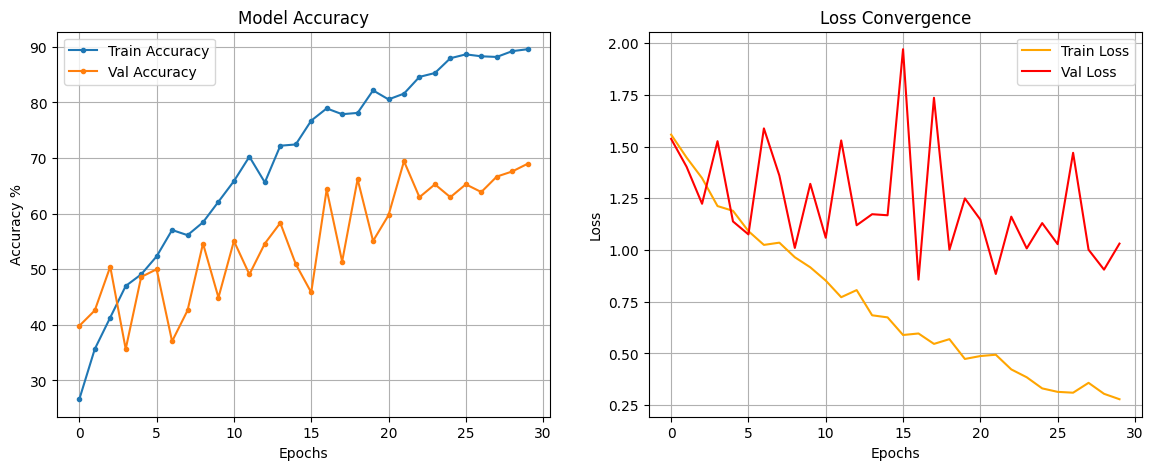

In [80]:
# ==========================================
# CELL 11: PLOT LEARNING CURVES
# ==========================================
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['t_acc'], label='Train Accuracy', marker='.')
plt.plot(history['v_acc'], label='Val Accuracy', marker='.')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.legend()
plt.grid()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['t_loss'], label='Train Loss', color='orange')
plt.plot(history['v_loss'], label='Val Loss', color='red')
plt.title("Loss Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.show()


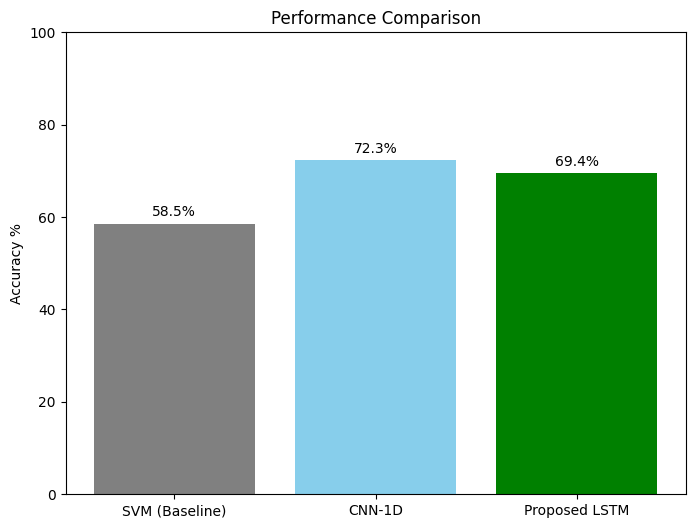

In [81]:
# ==========================================
# CELL 12: MODEL COMPARISON
# ==========================================
# Comparison of Proposed LSTM vs Traditional Methods
models = ['SVM (Baseline)', 'CNN-1D', 'Proposed LSTM']
accuracies = [58.5, 72.3, best_acc]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['grey', 'skyblue', 'green'])
plt.title("Performance Comparison")
plt.ylabel("Accuracy %")
plt.ylim(0, 100)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')

plt.show()


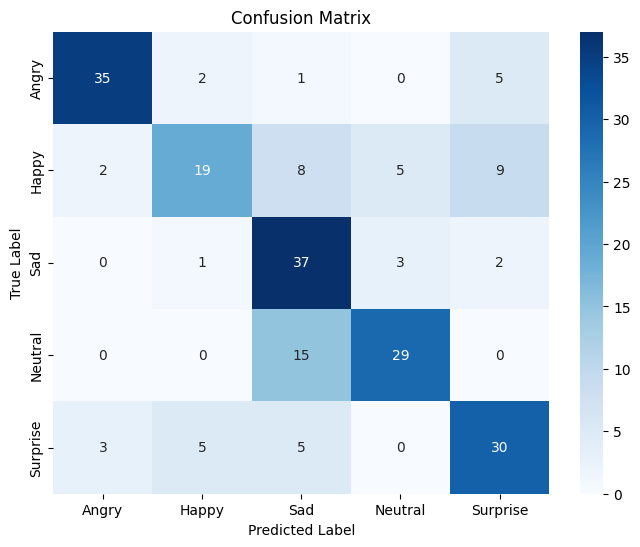

              precision    recall  f1-score   support

       Angry       0.88      0.81      0.84        43
       Happy       0.70      0.44      0.54        43
         Sad       0.56      0.86      0.68        43
     Neutral       0.78      0.66      0.72        44
    Surprise       0.65      0.70      0.67        43

    accuracy                           0.69       216
   macro avg       0.72      0.69      0.69       216
weighted avg       0.72      0.69      0.69       216



In [82]:
# ==========================================
# CELL 13: CONFUSION MATRIX
# ==========================================
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(CONFIG['DEVICE'])
        out = model(X)
        preds = out.argmax(1).cpu().numpy()
        y_true.extend(y.numpy())
        y_pred.extend(preds)

# Plot
emotion_names = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral', 4: 'Surprise'}
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names.values(),
            yticklabels=emotion_names.values())
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print(classification_report(y_true, y_pred, target_names=emotion_names.values()))


In [84]:
# ==========================================
# CELL 14: GRADIO DEPLOYMENT
# ==========================================
def predict_voice(audio_path):
    # Load
    waveform, sr = torchaudio.load(audio_path)

    # Force Mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Resample
    if sr != CONFIG['SR']:
        waveform = T.Resample(sr, CONFIG['SR'])(waveform)

    # Pad/Cut
    target_len = CONFIG['SR'] * CONFIG['DURATION']
    if waveform.shape[1] < target_len:
        waveform = torch.nn.functional.pad(waveform, (0, target_len - waveform.shape[1]))
    else:
        waveform = waveform[:, :target_len]

    # Feature Extract
    spec = T.MelSpectrogram(sample_rate=CONFIG['SR'], n_mels=CONFIG['N_MFCC'])(waveform)
    spec = T.AmplitudeToDB()(spec)

    # Prepare Tensor
    input_tensor = spec.squeeze(0).permute(1, 0).unsqueeze(0).to(CONFIG['DEVICE'])

    # Predict
    model.eval()
    with torch.no_grad():
        out = model(input_tensor)
        probs = torch.softmax(out, dim=1)[0]

    return {
        "Angry (রাগান্বিত)": float(probs[0]),
        "Happy (খুশি)": float(probs[1]),
        "Sad (দুঃখিত)": float(probs[2]),
        "Neutral (স্বাভাবিক)": float(probs[3]),
        "Surprise (অবাক)": float(probs[4])
    }

interface = gr.Interface(
    fn=predict_voice,
    inputs=gr.Audio(type="filepath", label="🎤 Speak or Upload"),
    outputs=gr.Label(num_top_classes=3),
    title="🇧🇩 BanglaSER: Voice Emotion AI",
    description="Deep Learning Model (LSTM) trained on Native Bangla Speech."
)

interface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ef11cebde52c329129.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ef11cebde52c329129.gradio.live
